# Eighth Exercise (BNNs and Ensembles)

This exercise focuses on Uncertainty in Deep Learning.

We will
- Implement an optimizer that uses a Stochastic Gradient Markov Chain Monte Carlo (SG-MCMC) method
- Implement a BNN
- See how uncertainty estimates can be derived using BNNs
- Plot these uncertainty estimates
- Implement an ensemble of NNs to get their uncertainty estimates and plot them


## 8.1 Bayesian inference in BNNs


BNNs define a distribution over the parameters of an NN. We then use the Bayes rule to calculate the posterior distribution over the parameters $\mathbf{\theta}$: 
<br><br>
    \begin{equation}
 \quad\quad   \quad\quad        p(\mathbf{\theta} \vert \mathbf{D})  = \frac{p(\mathbf{D} \vert \mathbf{\theta}) \cdot p(\mathbf{\theta})}{p(\mathbf{D})}  \quad.......\quad (\textbf{Eqn. 1})
    \end{equation}
    
where $\mathbf{D}$ is the data, $\mathbf{\theta}$ are the parameters.

Averaging the predictions over the posterior gives us the mean predictions of the BNN:
<br><br>
    \begin{equation*}
        \mathbf{\mu}_{BNN}(\mathbf{x}) = \intop BNN(\mathbf{x}; \mathbf{\theta}) \, p(\mathbf{\theta} \vert \mathbf{D}) \, d\mathbf{\theta}  \quad.......\quad (\textbf{Eqn. 2})
    \end{equation*}
    
and the variance in the predictions:
<br><br>
    \begin{equation*}
        \mathbf{\sigma^2}_{BNN}(\mathbf{x}) = \intop \Big( BNN(\mathbf{x}; \mathbf{\theta}) - \mathbf{\mu}_{BNN}(\mathbf{x}) \Big)^2 \, p(\mathbf{\theta} \vert \mathbf{D}) \, d\mathbf{\theta}  \quad.......\quad (\textbf{Eqn. 3})
    \end{equation*}

**Questions:**

- a) What does the averaging above achieve with regard to the generalisation capabilities of the network?
- b) Why would the averaging above usually be intractable for Neural Networks?

**Answers:** **TODO**

### 8.1.1 SG-MCMC methods for BNNs

Since exact inference in BNNs is usually intractable, here we will use Markov Chain Monte Carlo (MCMC) methods to average over sampled network parameters. Combining these with Stochastic Gradient methods gives us batch methods to update network parameters for BNNs and at the same time be able to sample them. Here we will implement a simple SG-MCMC method, preconditioned Stochastic Gradient Langevin Dynamics (pSGLD) from http://people.ee.duke.edu/~lcarin/aaai_psgld_final.pdf which basically preconditions the original SGLD from https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf by combining it with RMSProp.<br><br>**Note:** You don't have to read the papers to finish the exercise, the necessary equations adapted for our use are provided here.

#### 8.1.1.1 Stochastic Gradient Langevin Dynamics (SGLD)

In SGLD, we insert a bit of noise into the update step from SGD. We draw this noise from the normal distribution with a variance equal to the current learning rate. The update step for the parameters at time step $t$ then looks like:
<br><br>
    \begin{align}
\text{Estimate mini-batch gradient per sample:}\quad& \bar{\mathbf{g}}(\mathbf{\theta}_t;\mathbf{D}^{t}) \leftarrow -\underbrace{ \frac{1}{N} \nabla_{\mathbf{\theta}_t} \text{log}\, p(\mathbf{\theta}_t)}_{\text{Derivative of log prior}} - \underbrace{\frac{1}{n} \sum^{n}_{i=1} \nabla_{\mathbf{\theta}_t} \text{log}\, p(\mathbf{d}_{t_i}|\mathbf{\theta}_t)}_{\text{Derivative of log likelihood}}   \quad.......\quad (\textbf{Eqn. 4})\\
\text{Update parameters:}\quad& \mathbf{\theta}_{t+1} \leftarrow \mathbf{\theta}_{t} - \frac{\epsilon_t}{2} \big(N\bar{\mathbf{g}}(\mathbf{\theta}_t;\mathbf{D}^{t})\big) - \underbrace{\mathcal{N}(0, \epsilon_t \mathbf{I})}_{\text{Injected noise}}   \quad.......\quad (\textbf{Eqn. 5})\\
    \end{align}
where: <br> $n$ is the mini-batch size, <br>
$N$ is the total number of data points, <br>
$\mathbf{D}^{t} = \{\mathbf{d}_{t_1}, ..., \mathbf{d}_{t_n}\}$ is a randomly selected mini-batch of the data, 
<br>$\epsilon_t$ is the learning rate at time step $t$.

This is the normal stochastic gradient descent update step when the loss is the **negative log likelihood (NLL)** and with a prior distribution $p(\mathbf{\theta})$ imposed on the parameters with additional noise injected into the update step.

**Questions:**

- a) Assume we are maximising the posterior probability for the parameters given the data (i.e., Eqn. 1). Derive the SGLD update step (i.e., Eqn. 5) from that. <br>(**Note 1:** The learning rate is being divided by 2 here. **Note 2:** Typeset the answer in Latex.)

**Answers:** **TODO**

<br><br><br>

Initially, the noise in the stochastic gradient estimate dominates the injected noise in the update step but later on the injected noise dominates and the updated parameters at each step correspond to samples from the posterior distribution of the parameters (derivations in the original SGLD paper for those interested). We call the initial phase **burn-in** and the latter phase the **Langevin dynamics** phase. We can judge the end of the burn-in phase based on a sampling threshold calculated in the original SGLD paper. But for simplicity, here we use an empirically defined number of update steps to denote the burn-in phase.

#### 8.1.1.2 preconditioned Stochastic Gradient Langevin Dynamics (pSGLD)

pSGLD tries to improve upon SGLD by additionally using a preconditioner matrix for the update step to account for different curvatures in different dimensions. To implement pSGLD here, we inject noise similar to SGLD and precondition the update step with the preconditioner from RMSProp. For each time step $t$:
<br><br>
    \begin{align*}
\text{Estimate average of squared gradient:}\quad& \mathbf{V}(\mathbf{\theta}_t) \leftarrow \alpha \mathbf{V}(\mathbf{\theta}_{t-1}) + (1 - \alpha)\,\bar{\mathbf{g}}(\mathbf{\theta}_t;\mathbf{D}^{t}) * \bar{\mathbf{g}}(\mathbf{\theta}_t;\mathbf{D}^{t}) \quad.......\quad (\textbf{Eqn. 6})\\
\text{Estimate preconditioning matrix:}\quad& \mathbf{G}(\mathbf{\theta}_t) \leftarrow diag( \mathbf{1}\, / \,(\lambda\, \mathbf{1} + \sqrt{\mathbf{V}(\mathbf{\theta}_{t}} )) \quad.......\quad (\textbf{Eqn. 7})\\
\text{Update parameters:}\quad& \mathbf{\theta}_{t+1} \leftarrow \mathbf{\theta}_{t} - \frac{\epsilon_t}{2} (\mathbf{G}(\mathbf{\theta}_t) \big( N\bar{\mathbf{g}}(\mathbf{\theta}_t;\mathbf{D}^{t})\big) - \mathcal{N}(0, \epsilon_t (\mathbf{G}(\mathbf{\theta}_t)) \quad.......\quad (\textbf{Eqn. 8})\\
    \end{align*}

where: 
<br>$\alpha \in [0, 1]$ decides how much to weight old information in the exponential moving average of the squared gradient, <br>$\lambda$ is a small constant to avoid divison by zero, <br>$\mathbf{V}(\mathbf{\theta}_0) = \mathbf{0}$, <br>$\mathbf{1}$ is a vector with all $1s$ <br>and where required operations are carried out element-wise.


The next cell does some initial setup for this exercise. 

**Task:** 
Implement a pSGLD optimizer in the cell after the next.


In [1]:
# Some initial setup: Importing required libraries
import os
from typing import Tuple, List, Iterable

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
torch.manual_seed(0)

def minibatched(data: np.ndarray, batch_size: int) -> List[np.ndarray]:
    """Mini-batchifies data"""
    assert len(data) % batch_size == 0, ("Data length {} is not multiple of batch size {}"
                                         .format(len(data), batch_size))
    return data.reshape(-1, batch_size, *data.shape[1:])

def evaluate_loss(model: nn.Module, loss_func: nn.Module, 
                  x: torch.Tensor, y: torch.Tensor) -> Tuple[float, float]:
    """Evaluates given loss function for given data for the given model"""
    model.eval()
    correct = 0
    loss = []
    with torch.no_grad():
        output = model(x)
        loss = loss_func(output, y)
    return loss.numpy()

In [9]:
class pSGLD(torch.optim.Optimizer):
    """preconditioned Stochastic Gradient Langevin Dynamics (pSGLD) Optimizer"""

    def __init__(self, params: Iterable[nn.Parameter], lr: float, num_train_points: int,
                 alpha: float, lamb: float):
        """Init for various parameters of pSGLD, i.e., the hyperparams
        """
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr, num_train_points=num_train_points,
                        alpha=alpha, lamb=lamb)
        super(pSGLD, self).__init__(params, defaults)


    def step(self):
        """Performs a single optimization step.
        
        Implementation is similar to Pytorch's implementation of SGD here:
        https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html#SGD
        """

        for group in self.param_groups:
            for p in group['params']:
                
                if p.grad is None:
                    continue


                state = self.state[p]
                lr = group["lr"]
                num_train_points = group["num_train_points"]
                alpha = group["alpha"]  # alpha
                lamb = group["lamb"]  # lambda
                gradient = p.grad.data

                #  state initialization
                if len(state) == 0:
                    # START TODO ################
                    state["V"] = torch.zeros_like(gradient)
                    # END TODO ################

                # START TODO ################
                # Carry out the steps of pSGLD: Eqn. 6, 7 and 8
                # The gradient which is used here comes from eqn. 4. But you don't have
                # to worry about calculating it here. It will be auto-calculated by pytorch once 
                # you implement the NLLWithPriorLoss and use it later in the exercise.

                g = gradient.view(1, -1) # flatten the gradient
                state["V"] = alpha * state["V"] + (1 - alpha) * g * g

                ones = torch.ones_like(gradient)
                G = torch.diag(ones / (lamb * ones + torch.sqrt(state["V"])))

                noise = torch.distributions.multivariate_normal.MultivariateNormal(
                    torch.zeros_like(g),
                    lr * G
                ).sample()

                p.grad.data -= (lr * G * (num_train_points * g) + noise).view_as(g)

                # END TODO ################


### 8.1.2 Implement a BNN

**Question:**
- a) How would you modify the calculation of the mean and variance (from section 8.1 above) to get empirical estimates of those quantities for the BNN? (**Note:** Typeset the answer in Latex)

**Answer: TODO**

In [20]:


class BNN(nn.Module):    
    def __init__(self, model: nn.Module, burn_in: int, keep_every: int):
        """Initializes various parameters of the BNN
        
        model: Any neural network
        burn_in: Number of steps of the burn-in phase
        keep_every: Save a sample of the held network's parameters 
                    every keep_every steps after the burn-in phase
                    
        """
        super(BNN, self).__init__()
        # START TODO ########################
        # Maintain a state for the BNN including the current step
        # and currently held sampled network parameters.
        # What to code here will probably be clearer
        # after implementing the step() function below

        self.burn_in = burn_in
        self.keep_every = keep_every
        self.step_num = 0
        self.models = list()

        # END TODO ########################

    # Since the BNN has to take samples of the networks, we implement a step() function for the BNN as well.        
    def step(self):
        """Implements the step function of the BNN"""
        # START TODO ########################
        # Sample the held neural network's parameters here by saving them to the BNN's state
        # Note: It'd be easier to just save a deepcopy of the whole neural network.
        # Remember to sample only after the burn-in phase is done and then sample every
        # keep_every steps

        self.step_num += 1
        if self.step_num <= self.burn_in:
            return
        
        if (self.step_num - self.burn_in) % keep_every == 0:
            self.models.append(copy.deepcopy(self.model))

        # END TODO ########################
        
    def forward(self, x) -> torch.Tensor:
        """Forward pass of the BNN"""
        return self.model(x)

    def predict_mean_and_std(self, x, 
                             return_individual_predictions: bool = False) -> Tuple[torch.Tensor, torch.Tensor]:
        """Returns mean and standard deviation of the predictions of the sampled networks
        
        In case return_individual_predictions is True, return all the predictions of the sampled networks, 
        as a Torch tensor
        """
        # START TODO ########################
        # When training or before the burn-in phase is completed,
        # we don't intend to get uncertainty estimates in the
        # predictions anyway, so just return the output from
        # the normal forward pass and the standard deviation as 0, 
        # otherwise return the mean of the predictions and standard deviation
        # of the sampled networks.

        # We will be predicting the mean and the log variance of the data (see slide 47 of lecture)
        # in later code below. So the first dimension of the netowrk outputs will be the mean
        # and the 2nd dimension will be the log variance
        # which amounts to the observational noise. So, don't forget
        # to add the variances from the predicted variance (i.e., exp of 2nd dimension of output)
        # to the empirical variance of the mean (i.e., variance of 1st dimension of output) 
        # according to the law of total variance. Be extra careful with where you take squares
        # and exp()s, etc.!!

        # In case, return_individual_predictions is True, return
        # all the predictions of all the sampled networks.

        if self.step_num <= self.burn_in or self.training:
            return self(x), 0

        predictions = torch.stack(map(lambda model: model(x), self.models))
        predicted_var = torch.exp(predictions[0, 1])
        empirical_mean, _ = torch.mean(predictions, dim=0)
        empirical_var, _ = torch.var(predictions, dim=0)

        return empirical_mean, torch.log(predicted_var + empirical_var)

        # END TODO ########################
        

### 8.1.3 Sinc function

We will be performing regession on the sinc function. It is defined as:
<br><br>
    \begin{equation*}
        sinc(x) = \frac{sin(x)}{x}
    \end{equation*}
    
The value at x = 0 is defined to be the limiting value, equal to 1.

**Task:**
Please complete the code to plot the function in the next cell.

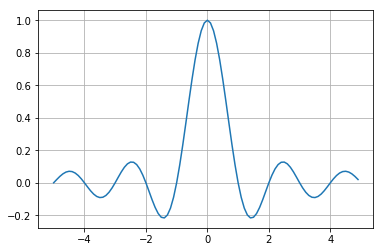

In [22]:
# START TODO ########################
# Note: You can use the sinc implementation from numpy
xs = np.arange(-5, 5, 0.1)
ys = np.sinc(xs)

plt.grid(True)
plt.plot(xs, ys)
# END TODO ########################

### 8.1.4 Loss function

We will be minimizing the negative log likelihood (NLL) loss + negative log prior function in our algorithm. This corresponds to the negative log of the numerator in eqn. 1, i.e.:
<br>
\begin{equation}
-\underbrace{\text{log}\, p(\mathbf{D} \vert \mathbf{\theta})}_{\text{Log likelihood}} -\underbrace{\text{log}\, p(\mathbf{\theta})}_{\text{Log prior}}
\end{equation}
#### Prior component of the loss
Here we will model this prior using a normal distribution and impose this prior only on the weights of the network:
<br><br>
    \begin{equation}
        p(\mathbf{\theta}) = \mathcal{N}(0, \mathbf{\sigma}^{2}_{\mathbf{\theta}})  \quad.......\quad (\textbf{Eqn. 9})
    \end{equation}
<br>
We set this $\mathbf{\sigma}^{2}_{\mathbf{\theta}}$ equal to the constant 1 here. The prior can be seen to have a regularising effect on the weights of the network.
<br>

**Note:** This variance on the parameters of the network is different from the variance of the output. The variance in the parameters is what is used in BNNs to sample different sets of parameters for the BNN while the variance in the output can capture something like noise in the data and could be used even for other types of neural networks.
<br>

#### NLL component of the loss
In order to use the NLL function we need a probability density for the output of the model given its inputs and parameters. Here we will model this probability using a normal distribution. So:
<br><br>
    \begin{align}
        p(\mathbf{D} \vert \mathbf{\theta}) &= \prod^{N}_{i=1}p(\mathbf{d}_{i}|\mathbf{\theta}) \quad.......\quad (\textbf{Eqn. 10}) \\
    \end{align}
<br>
where: <br>
$\mathbf{D} = \{\mathbf{d}_{1}, ..., \mathbf{d}_{N}\}$ is the data <br>
and $\mathbf{d}_{i} = (\mathbf{x}_i, y_i)$ is data point $i$.
<br>

Taking negative log and assuming normal distribution, we get:
<br>
    \begin{align}
        \quad\quad\quad\quad &= -\sum^{N}_{i=1}\text{log}\,\mathcal{N}(\hat{y}_{i}, \hat{\sigma}^{2}_{i}) \quad.......\quad (\textbf{Eqn. 11}) \\
        &\big[\text{where $\hat{y}_{i}$ is the mean prediction and $\hat{\sigma}^{2}_{i}$ is the variance prediction of the model for data point $i$}\big] \\
        &= \frac{\text{log}\,\hat{\sigma}^{2}_{i}}{2} + \frac{\text{log}\,2\pi}{2} + \frac{(y_i - \hat{y}_i)^2}{2\hat{\sigma}^{2}_{i}} \quad.......\quad (\textbf{Eqn. 12})
    \end{align}
<br>


The normal distribution is completely characterised by its mean and variance. In order to get these parameters of the distribution, we will predict them using a neural network.
<br>

If the variance of output doesn't depend on the input, then we have **homoscedasticity**. Otherwise, we have heteroscedasticity. Here let's assume that the variance captures the noise in the data and that this noise has constant variance independent of the input. 
<br>

We will predict the mean using a neural network like we normally do. In order to get the variance, we will use an additional homoscedastic layer at the end of the neural network to output the log of the variance.

In the next cell, we will implement the NLL loss with a prior and also a homoscedastic layer for a neural network.

**Questions:**
- a) Why can't we use the NLLLoss implemented in PyTorch?
- b) Derive the log prior component of the loss with respect to the neural network's parameters when modelling the prior as the normal distribution above with $\mathbf{\sigma}^{2}_{\mathbf{\theta}}$ = 1. <br>(**Note:** It's the derivative of the log prior from Eqn. 4 above that needs to be found in the specific case when the prior is a normal distribution.)
- c) Why would minimizing the NLL loss be equivalent to minimising the MSE loss for homoscedastic data but not necessarily for heteroscedastic data? <br>(**Note:** No need to derive the whole thing, just an answer in words is enough)

**Answers: TODO**

<br><br><br>

**Task:**
Please implement the missing parts of the code in the next cell.

In [ ]:
class NLLWithPriorLoss(nn.Module):
    def __init__(self, params: Iterable[nn.Parameter], num_train_points: int):
        """Init for NLLWithPriorLoss
        
        We need num_train_points because the log prior component from eqn. 4
        is divided by num_train_points.

        We need params to calculate the log prior component in eqn. 4.
        Remember to instantiate an object of this class with model.named_parameters() 
        so that we can check for which parameters to use the prior. In this case, we 
        impose a Gaussian prior only on the weight parameters.
        """
        super(NLLWithPriorLoss, self).__init__()
        self.parameters = list(params)
        self.num_train_points = num_train_points

    def forward(self, input, target) -> torch.Tensor:
        """Implement forward for the loss function.
        
        Perform the Stochastic Gradient and log prior calculations from eqn. 4.
        Don't forget to divide the log likelihood by batch_size and to divide the log
        prior by the num_train_points. These will be rescaled by num_train_points
        in the pSGLD optimizer.
        
        Please remember that the neural net has 2 outputs: the mean and the log variance.
        """
        # START TODO ########################

        # END TODO ########################        
        return -log_likelihood

class HomoscedasticLogVar(nn.Module):
    """This will be last layer of the Neural Network we train.
    It takes the normal output of the neural network until that point,
    i.e. the mean prediction, and just appends a vector containing the
    log variance which best explains the data, i.e., which minimizes the loss.
    """
    def __init__(self, logvar, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.logvar = nn.Parameter(torch.FloatTensor([[logvar]]))

    def forward(self, x):
        # START TODO ########################
        # Concatenate the predicted log variance with x,
        # This will result in 2 outputs for the neural net
        # when we append this layer to a normal NN with one output.

        # END TODO ########################


### 8.1.5 Evaluation

**Task:**
Implement parts of the evaluate_model() function which takes a BNN along with an optimizer and a learning rate scheduler and trains the BNN in the next cell.

In [ ]:
def evaluate_model(model, optimizer, loss_func, scheduler, x_train, y_train, x_test, y_test, epochs, batch_size):
    print("Training and evaluating model...")

    train_losses = []
    test_losses = []

    for epoch in range(int(epochs)):
        print("  Epoch {} / {} ...".format(epoch + 1, epochs).ljust(2))
        # START TODO ########################
        # END TODO ########################

        ix = np.arange(len(x_train))
        np.random.shuffle(ix)
        
        shuffled_data = zip(minibatched(x_train[ix], batch_size), minibatched(y_train[ix], batch_size))

        for i, (x, y) in enumerate(shuffled_data):
            # START TODO ########################
            # Don't forget to call model.step() in case you call this function on the BNN from above
            # END TODO ########################
        train_loss = evaluate_loss(model, loss_func, x_train, y_train)
        test_loss = evaluate_loss(model, loss_func, x_test, y_test)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print('Train loss:', train_losses[-1], 'Test loss:', test_losses[-1])

    return train_losses, test_losses


**Task:** Now write the code which uses the above code to train the BNN. The scheduler needs to have a decreasing schedule for the learning rate, otherwise the algorithm may not converge.


In [ ]:
# We have selected the hyperparamters for you below.
n_train = 30
epochs = 10000
batch_size=n_train//2
lr = 1e-3

np.random.seed(42)
x = np.random.uniform(0, 1, n_train)
y = np.sinc(x * 10 - 5)

x = torch.FloatTensor(x[:, None])
y = torch.FloatTensor(y[:, None])

x_test = np.random.uniform(0, 1, 20)
y_test = np.sinc(x_test * 10 - 5)
x_test = torch.from_numpy(x_test[:, None]).float()
y_test = torch.from_numpy(y_test[:, None]).float()

model = nn.Sequential(
  nn.Linear(in_features=1, out_features=50, bias=True),
  nn.Tanh(),
  nn.Linear(in_features=50, out_features=50, bias=True),
  nn.Tanh(),
  nn.Linear(in_features=50, out_features=50, bias=True),
  nn.Tanh(),
  nn.Linear(in_features=50, out_features=1, bias=True),
  HomoscedasticLogVar(np.log(1e-3))
)

# Note: The number of burn-in steps is the total number of mini-batch steps
# while the number of epochs counts passes over the whole batch
bnn = BNN(model, burn_in=15000, keep_every=50)
criterion = NLLWithPriorLoss(bnn.named_parameters(), num_train_points=n_train)
optimizer = pSGLD(bnn.parameters(), lr=lr, num_train_points=n_train, 
                  alpha=0.99, lamb=1e-5)

lambda1 = lambda epoch: 1/(epoch//20 + 1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

# START TODO ########################
# END TODO ########################



### 8.1.6 Plotting

**Task:**
Plot the training and test curves for the BNN runs from above.

In [ ]:
# START TODO ########################
# With NLL loss, the initial losses are really huge compared to the later one
# so plot only from, say, the 10th loss onwards.
# END TODO ########################

**Question:**
- a) What do you observe regarding the test loss later on? What does this tell you?

**Answer: TODO**


**Task:** Plot uncertainties in the predictions of the BNN below. Use fill_between() from matplotlib to fill in the area around the mean covered by 1, 2 and 3 standard deviations. Vary the alpha (opacity) values of these to get a good visualization of the uncertainties.

In [ ]:
def plot_uncertainty(model):
    xlim = (-0, 1)
    ylim = (-2, 2)
    grid = np.linspace(*xlim, 200)
    # START TODO ########################
    # Use the predict_mean_and_std() function of the BNN to get mean predictions
    # and standard deviations to plot uncertainties. Plotting mean prediction using plot()
    # and fill_between() from matplotlib should be helpful
    # END TODO ########################
    plt.legend(loc='best')
    plt.xlabel('x value')
    plt.ylabel('y value')

    plt.show()

plot_uncertainty(bnn)

**Question:**
- a) What do you observe in the graph?

**Answer: TODO**

**Task:** Plot the predictions of the individual networks (i.e., the networks with the different sets of parameters from the posterior) of the BNN below. Plot each prediction with a smaller alpha (opacity) so that we can get an idea of the predictions of all the individual networks.

In [ ]:
def plot_multiple_predictions(model):
    # START TODO ########################
    # Use the predict_mean_and_std() function of the BNN with return_individual_predictions = True
    # to get individual predictions for each of the sampled set of parameters of the BNN.
    # Plot all of these one by one using plot() with some transparency using its alpha parameter
    # so that you get a good visualization of the individual predictions
    # END TODO ########################
    plt.legend(loc='best')
    plt.xlabel('x value')
    plt.ylabel('y value')

    plt.show()
    
plot_multiple_predictions(bnn)

### Your Feedback on Exercise 8.1
**pSGLD:<br>
BNN:<br>
NLLWithPriorLoss and HomoscedasticLogVar:<br>
Plotting:<br>
**

## 8.2 Uncertainties using Ensembles

**Task:**
Complete the code for training an ensemble of NNs below.

In [ ]:
class EnsembleSequential(nn.Sequential):
    """Holds an ensemble of NNs which are used to get prediction means and uncertainties
    similar to the BNNs above"""
    def __init__(self, *args, num_models=5, ensembled_nets, **kwargs):
        """Init for the class"""
        super(EnsembleSequential, self).__init__(*args, **kwargs)
        self.num_models = num_models
        self.ensembled_nets = ensembled_nets
    
    def predict_mean_and_std(self, x, 
                             return_individual_predictions: bool = False) -> Tuple[torch.Tensor, torch.Tensor]:
        """Returns mean and standard deviation of the predictions of the ensembled networks
        
        In case return_individual_predictions is True, return all the predictions of the ensembled networks, 
        as a Torch tensor
        """
        # START TODO ########################
        # The code here is very similar to the predict_mean_and_std() from the BNNs above.
        # END TODO ########################
        return mean, std

ensembled_nets = []
num_models=5

# The initialization of the weights turns out to be crucial for getting good uncertainty estimates,
# so we do that here.
def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.normal_(module.weight, mean=0, std=2)
        nn.init.constant_(module.bias, val=0.0)


for i in np.arange(num_models):
    temp_model = nn.Sequential(
      nn.Linear(in_features=1, out_features=50, bias=True),
      nn.Tanh(),
      nn.Linear(in_features=50, out_features=50, bias=True),
      nn.Tanh(),
      nn.Linear(in_features=50, out_features=1, bias=True),
    ).apply(init_weights)
    ensembled_nets.append(temp_model)

ensemble = EnsembleSequential(ensembled_nets=ensembled_nets)

for i in np.arange(num_models):
    criterion = torch.nn.MSELoss()
    epochs=10000
    lr = 1e-2
    optimizer = torch.optim.SGD(ensemble.ensembled_nets[i].parameters(), lr=lr)
    lambda1 = lambda epoch: 1.
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
    # START TODO ########################
    # END TODO ########################

    


In [ ]:
plot_uncertainty(ensemble)

In [ ]:
plot_multiple_predictions(ensemble)

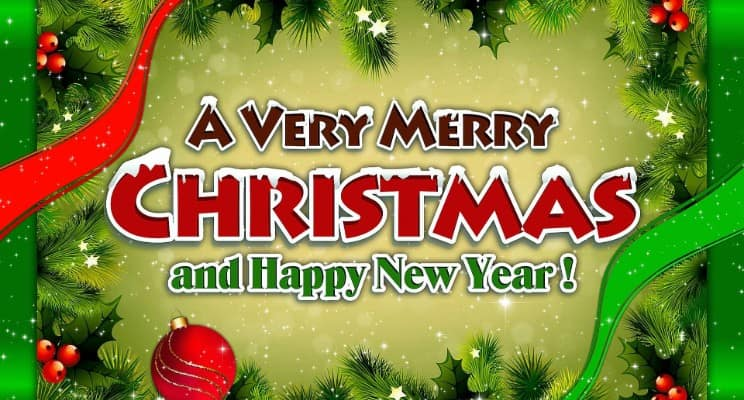

### Your Feedback on Exercise 8.2
**Ensembles:**